In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

def get_all_filenames(file_type, model_output_path="model_output/", finals_only=False, intermediates_only=True, ignore_chimeric=True) -> list:
    """
      fuzzy list of all filenames of a specific type in a directory:
    """
    if file_type=="seed":
        ext="csv"
    else: 
        ext="parquet"
    l = []
    for f in Path(str(model_output_path)).rglob(f'*.{ext}'):
        f = str(f)
        if file_type in f:
            if (finals_only and "final" in f) or (intermediates_only and "intermediate" in f) or (not finals_only and not intermediates_only):
                if not (ignore_chimeric and "chimeric" in f):
                    l.append(str(f))
    return l

class RunInfo():
    """ Store the information to reproduce and buid a run"""
    def __init__(self, run_id, config_path=None, folder_path=None):
        self.run_id = run_id
        self.config_path = config_path
        self.folder_path = folder_path
        self.gempyor_simulator=None

    def get_all_filenames(self, file_type, finals_only=False, intermediates_only=True, ignore_chimeric=True) -> list:
        return get_all_filenames(file_type, model_output_path=self.folder_path, finals_only=finals_only, intermediates_only=intermediates_only, ignore_chimeric=ignore_chimeric)


mask10 = '00000001'   # So we just do

max_files = -1  # files to load for median an Qx
max_files_deep = 10 # number of files for deep inspection, or singled out in plots

data_dir = "RSV_USA/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

### Setup manual

In [2]:
config_name = f"config_rsv_simplified_inference_v3_MD.yml"
run_id = "config_rsv_simplified_inference_v3_MD.yml"

## Create gempyor object

In [3]:

fs_results_path = "model_output" 

run_info = RunInfo(run_id = run_id, 
                   config_path= f"{data_dir}/{config_name}",
                   folder_path = f"{fs_results_path}")

run_info.gempyor_simulator = gempyor.GempyorSimulator(
    config_path=run_info.config_path,
    run_id=run_info.run_id,
    #prefix=f"USA/inference/med/{run_id}/global/intermediate/000000001.",
    seir_modifiers_scenario="none",
    outcome_modifiers_scenario="IHRadj",
    first_sim_index=1,
    stoch_traj_flag=False,
    path_prefix=f"{data_dir}/",  # prefix where to find the folder indicated in spatial_setup$
)

#run_info.gempyor_simulator.update_prefix(new_prefix=f"config_rsv_simplified_inference_v3_MD/{run_id}")
node_names = run_info.gempyor_simulator.modinf.subpop_struct.subpop_names

CRITICAL:root:No mobility matrix specified -- assuming no one moves


./config_rsv_simplified_inference_v3_MD.yml
  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> ModelInfo rsv_rd1_counterfactual_inference_overlap_MD_none_IHRadj; index: 1; run_id: config_rsv_simplified_inference_v3_MD.yml,
  gempyor >> prefix: rsv_rd1_counterfactual_inference_overlap_MD_none_IHRadj/config_rsv_simplified_inference_v3_MD.yml/;


In [ ]:
node_names

## This file analysis a gempyor object

In [13]:
gempyor.config.set_file(run_info.config_path)
gt = pd.read_csv(f"{data_dir}/"+gempyor.config["inference"]["gt_data_path"].get())
# gt
statistics = {}
# # Ingoring agreegation and all, assuming by weekP
for stat in gempyor.config["inference"]["statistics"]:
    statistics[gempyor.config["inference"]["statistics"][stat]["sim_var"].get()] = gempyor.config["inference"]["statistics"][stat]["data_var"].get()
statistics
gt = gempyor.read_df(gempyor.config["inference"]["gt_data_path"].get())
gt["date"]= pd.to_datetime(gt['date'])
gt = gt.set_index("date")

In [42]:
import pyarrow as pa
ds = pq.ParquetDataset('test/', 
                       partitioning=["run_uid", "run_id","ftype","llik","type"])
df = ds.read().to_pandas()

#df = pa.Table.from_pandas(a, preserve_index=False)
#pa.parquet.write_table(df, "all_rsv")

In [46]:
df = df[df["type"]=="final"].reset_index()
df = pa.Table.from_pandas(df, preserve_index=False)
pa.parquet.write_table(df, "all_final_hosp_rsv")

In [ ]:
df=df.set_index("date")

In [5]:
import dask
import dask.dataframe as dd

In [6]:
file_list=get_all_filenames(file_type="hosp", model_output_path="test", finals_only=True, intermediates_only=False)

In [ ]:
len(file_list)

In [ ]:
filename=file_list[0]
df = gempyor.read_df(filename)   

In [7]:
#@dask.delayed
def read_and_label_hosp(filename):
    # reads each csv file to a pandas.DataFrame
    df = gempyor.read_df(filename)               
    df['slot'] = int(filename.split('/')[-1].split('.')[0])
    #df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    #df_csv = df_csv[df_csv['quantity'] == 'probability']
    #df_csv['USPS'] = df_csv['geoid'].map(geodata.set_index('geoid')['USPS']) # https://stackoverflow.com/questions/36413993/replace-column-values-in-one-dataframe-by-values-of-another-dataframe
    #df_csv = pd.merge(df_csv, geodata, on=['geoid'], how='inner')
    #df_csv = df_csv.drop('geoid', axis = 1)
    #df_csv = df_csv.groupby(['USPS', 'slot','sim']).mean().reset_index()#.set_index('time', drop=True)
    #df_csv = df_csv[['value','sim', 'slot', 'outcome', 'USPS']]
    return df

# create a list of functions ready to return a pandas.DataFrame
dfs = [dask.delayed(read_and_label_hosp)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddf = dd.from_delayed(dfs)
#postST = ddf.groupby(['sim','slot','outcome', 'USPS']).sum().compute(scheduler="threads")
#postST =  postST.reorder_levels(['outcome','USPS','slot','sim']).sort_index().reset_index()
#resultST[run_name] = postST

In [8]:
df = ddf.compute().reset_index(drop=True)

In [ ]:
dfl['slot'].unique()

In [ ]:
subpop="California"
hosp_col='incidH_age0to4'
dfl = df[(df["subpop"]==subpop)]
tp = dfl[[hosp_col, 'slot', 'date']].pivot(columns='slot', values=hosp_col, index='date')

In [ ]:
tp.quantile([0.5, 0.7], axis=1)

In [14]:
gt

,subpop,incidH_all,incidH_0_4,incidH_18_49,incidH_50_64,incidH_5_17,incidH_65_100
date,,,,,,,
1989-01-01,California,7.728136,4.296087,NaN,NaN,0.000000,NaN
1989-01-01,Colorado,2.034232,1.178571,NaN,NaN,0.430358,NaN
1989-01-01,Maryland,0.000000,0.000000,NaN,NaN,0.000000,NaN
1989-01-02,California,8.541624,4.748306,NaN,NaN,0.000000,NaN
1989-01-02,Colorado,2.034232,1.473214,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...
2024-01-10,Colorado,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-10,Maryland,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-11,California,NaN,NaN,NaN,NaN,NaN,NaN


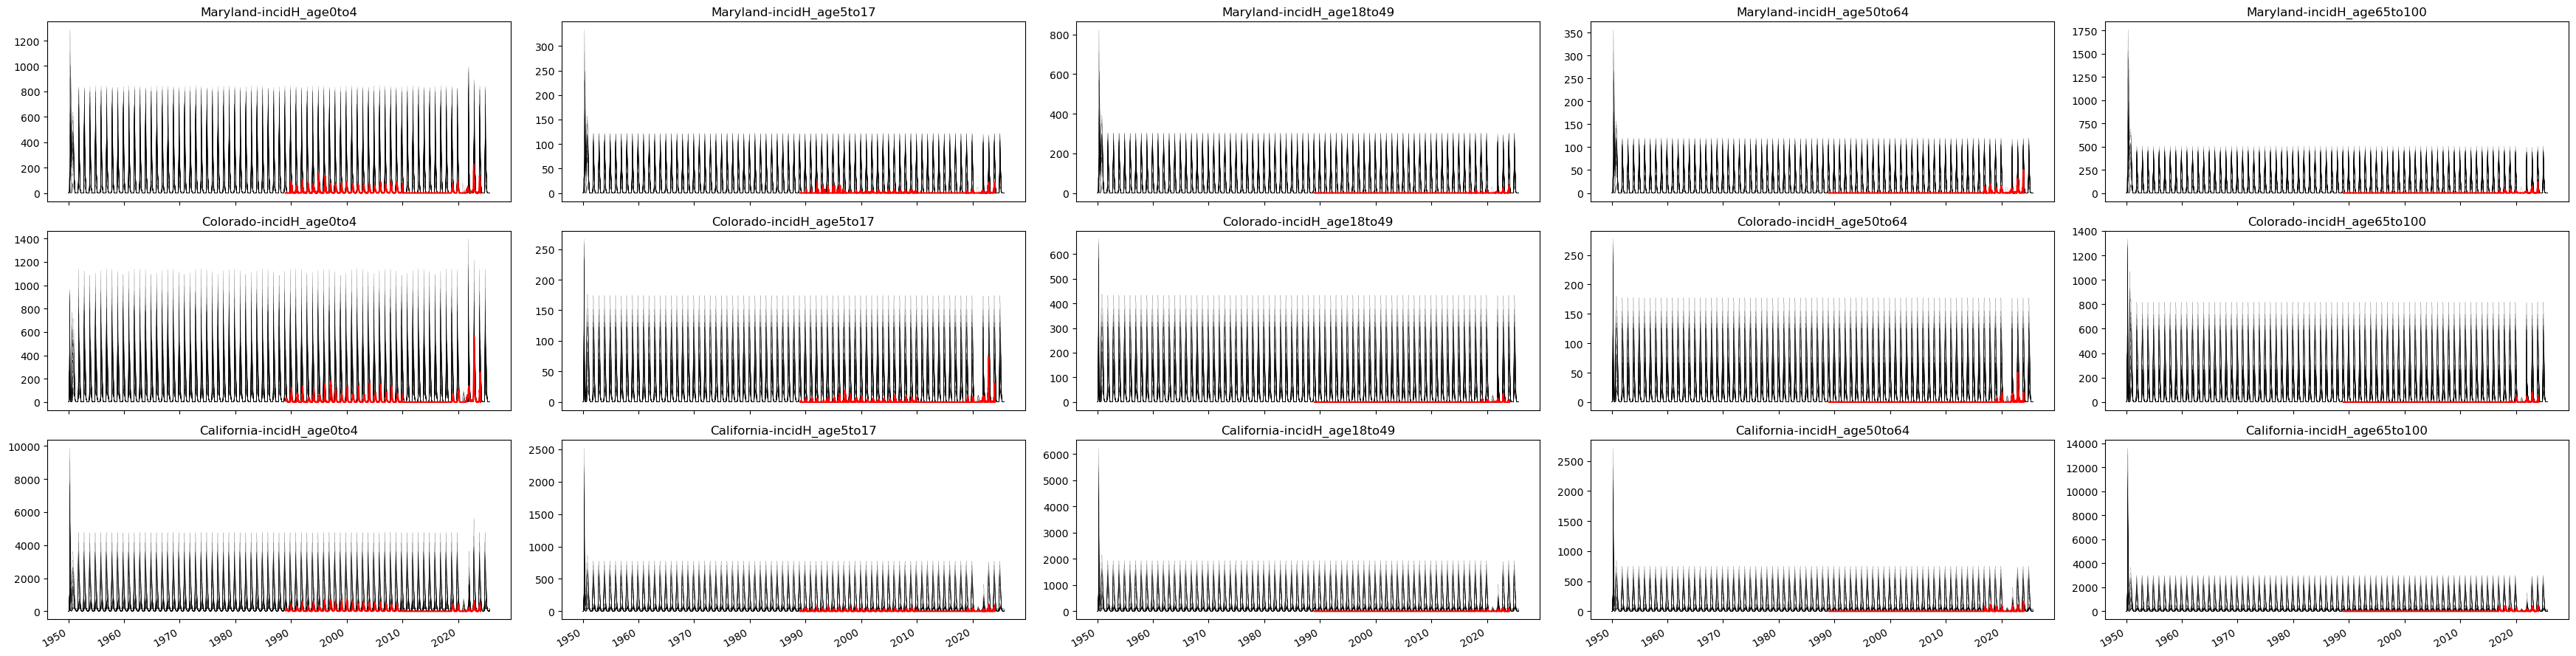

In [39]:
nax1, nax2 = len(df["subpop"].unique()), len(statistics)

fig, axes = plt.subplots(nax1, nax2, 
                            figsize=(nax2*7, nax1*3), 
                            sharex=True)

for i, subpop in enumerate(df["subpop"].unique()):
    dfl = df[(df["subpop"]==subpop)]
    gtl = gt[gt["subpop"]==subpop]

    for j, (hosp_col, gt_col) in enumerate(statistics.items()):
        tp = dfl[[hosp_col, 'slot', 'date']].pivot(columns='slot', values=hosp_col, index='date').resample('W-SAT').sum()
        ax = axes[i,j]
        ax.set_title(f"{subpop}-{hosp_col}")
        ax.plot(tp, lw=.1, c='k')
        ax.plot(gtl[gt_col].resample('W-SAT').sum(), color='r')

#fig.suptitle(f"{len(run_indexes)}  snpi draws (red), \n mean of all geoids") # config draws (black) and
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("all_sim.pdf")

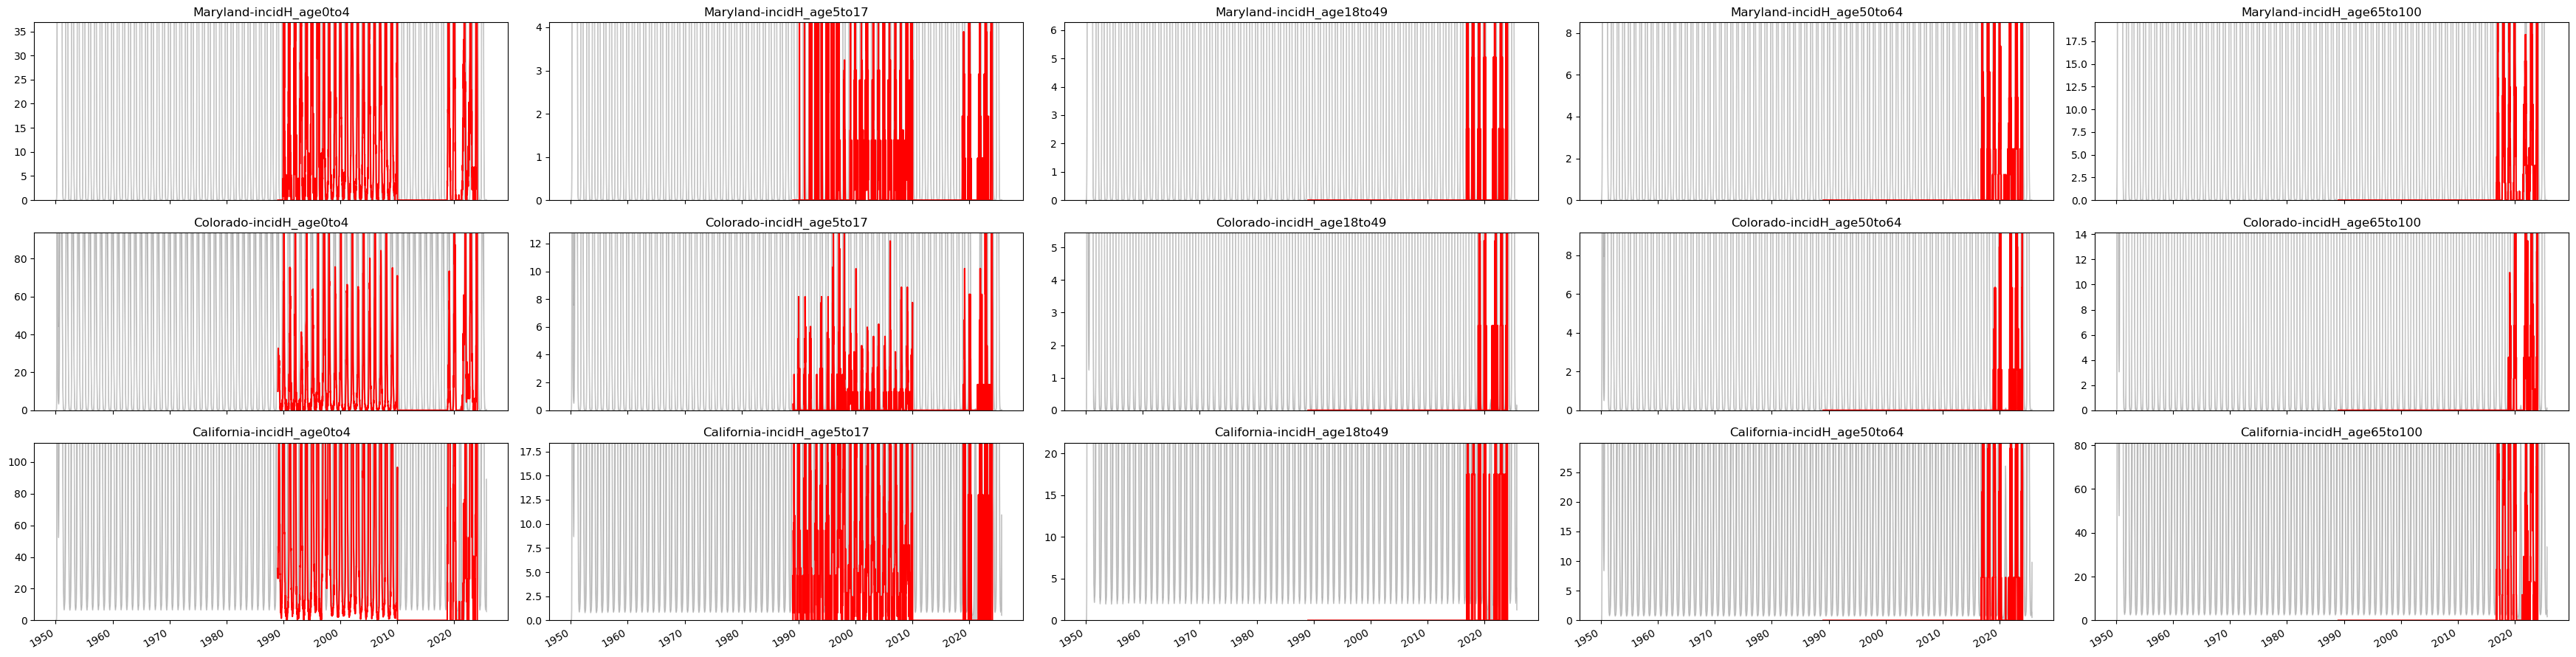

In [41]:
nax1, nax2 = len(df["subpop"].unique()), len(statistics)

fig, axes = plt.subplots(nax1, nax2, 
                            figsize=(nax2*7, nax1*3), 
                            sharex=True)

for i, subpop in enumerate(df["subpop"].unique()):
    dfl = df[(df["subpop"]==subpop)]
    gtl = gt[gt["subpop"]==subpop]

    for j, (hosp_col, gt_col) in enumerate(statistics.items()):
        tp = dfl[[hosp_col, 'slot', 'date']].pivot(columns='slot', values=hosp_col, index='date').resample('W-SAT').sum()
        
        ax = axes[i,j]
        ax.set_title(f"{subpop}-{hosp_col}")
        quant = tp.quantile([0.025, 0.25, 0.75, 0.975], axis=1).T
        #ax.fill_between(quant.index, quant[0.025], quant[0.975], alpha=.2, color='grey')
        ax.fill_between(quant.index, quant[0.25], quant[0.75], alpha=.4, color='grey')
        ax.plot(gtl[gt_col].resample('W-SAT').sum(), color='r')
        if not np.isnan(np.nanmax(gtl[gt_col])):
            ax.set_ylim(0, np.nanmax(gtl[gt_col])+.10*np.nanmax(gtl[gt_col]))

#fig.suptitle(f"{len(run_indexes)}  snpi draws (red), \n mean of all geoids") # config draws (black) and
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("quantiles.pdf")

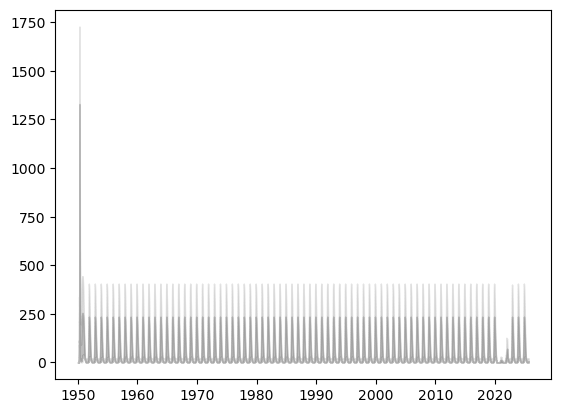

In [21]:
quant

,0.025,0.250,0.750,0.975
date,,,,
1950-01-01,0.000000,0.000000,0.000000,0.000000
1950-01-02,0.000000,0.000000,0.000000,0.000000
1950-01-03,0.000000,0.000000,0.000000,0.000000
1950-01-04,0.000000,0.000000,0.000000,0.000000
1950-01-05,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2025-08-28,0.471389,0.702638,5.289646,21.896415
2025-08-29,0.471389,0.702638,5.289646,21.896415
2025-08-30,0.495420,0.738645,6.207639,21.899497


In [ ]:
import pyarrow.dataset
import pyarrow as pa
partitioning = pyarrow.dataset.FilenamePartitioning(
    pa.schema([("slot", pa.int16()), ("run_id", pa.string()), ("type", pa.string())]),
    segment_encoding='none')
print(partitioning.parse("000000004.rsv_simplified_CA.hosp.parquet"))

In [ ]:
from gempyor import config

config.read(user=False)
config.set_file(run_info.config_path)

run_info.gempyor_simulator.one_simulation(sim_id2write=0, load_ID=False, sim_id2load=0)

## Analyze llik files

In [ ]:
llik_filenames = run_info.get_all_filenames("llik", intermediates_only=True)
print(f"loaded {len(llik_filenames)} llik files")

In [ ]:
if len(llik_filenames)>0:
    full_df = []
    file_list = llik_filenames[:max_files]
    for filename in file_list:
        df_raw = pq.read_table(filename).to_pandas()               
        df_raw['slot'] = int(filename.split('/')[-1].split('.')[0])
        df_raw['sim'] = int(filename.split('/')[-1].split('.')[1])
        try: 
            int(filename.split('/')[-1].split('.')[2])   # weird some files are duplicated TODO
        except:
            df_raw['ID'] = run_info.run_id
            df_raw = df_raw.drop("filename", axis=1)
            #df_csv = df_csv.groupby(['slot','sim', 'ID', 'geoid']).sum().reset_index()
            #df_csv = df_csv[['ll','sim', 'slot', 'ID','geoid']]
            full_df.append(df_raw)
        else:
            pass
            
    full_df = pd.concat(full_df)


In [ ]:
if len(llik_filenames)>0:
    full_df.groupby(['sim', 'slot']).sum()

In [ ]:
if len(llik_filenames)>0:
    fig, axes = plt.subplots(len(node_names)+1,4, figsize=(4*4,len(node_names)*3), sharex=True)

    colors = ['b', 'r', 'y', 'c']
    icl = 0

    idp = 0
    all_nn =  full_df.groupby(['sim', 'slot']).sum().reset_index()[['sim', 'slot','ll', "accept", "accept_avg", "accept_prob"]]
    for ift, feature in enumerate(["ll", "accept", "accept_avg", "accept_prob"]):
        lls = all_nn.pivot(index='sim', columns='slot', values=feature)
        if feature=="accept":
            lls = lls.cumsum()
            feature = "accepts, cumulative"
        axes[idp,ift].fill_between(lls.index, lls.quantile(.025, axis = 1), lls.quantile(.975, axis = 1), alpha = .1, color = colors[icl])
        axes[idp,ift].fill_between(lls.index, lls.quantile(.25, axis = 1), lls.quantile(.75, axis = 1), alpha = .1, color = colors[icl])
        axes[idp,ift].plot(        lls.index, lls.median(axis=1), marker = 'o', label = run_id, color = colors[icl])
        axes[idp,ift].plot(lls.index, lls.iloc[0:max_files_deep],color = 'k', lw=.3)
        axes[idp,ift].set_title(f"National, {feature}")
        axes[idp,ift].grid()

    for idp, nn in enumerate(node_names):
        idp = idp+1
        all_nn =  full_df[full_df['geoid']==nn][['sim', 'slot','ll', "accept", "accept_avg", "accept_prob"]]
        for ift, feature in enumerate(["ll", "accept", "accept_avg", "accept_prob"]):
            lls = all_nn.pivot(index='sim', columns='slot', values=feature)
            if feature=="accept":
                lls = lls.cumsum()
                feature = "accepts, cumulative"
            axes[idp,ift].fill_between(lls.index, lls.quantile(.025, axis = 1), lls.quantile(.975, axis = 1), alpha = .1, color = colors[icl])
            axes[idp,ift].fill_between(lls.index, lls.quantile(.25, axis = 1), lls.quantile(.75, axis = 1), alpha = .1, color = colors[icl])
            axes[idp,ift].plot(        lls.index, lls.median(axis=1), marker = 'o', label = run_id, color = colors[icl])
            axes[idp,ift].plot(lls.index, lls.iloc[0:max_files_deep],color = 'k', lw=.3)
            axes[idp,ift].set_title(f"{nn}, {feature}")
            axes[idp,ift].grid()
            if idp == len(node_names)-1:
                axes[idp,ift].set_xlabel('sims')
            # ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    fig.tight_layout()
    plt.savefig(f"pplot_llik_{run_id}_{job_name}.pdf")

## NPIs chains

In [ ]:
npis_filenames = get_all_filenames("snpi", all_runs, intermediates_only=False, finals_only=True)
#npis_filenames[run_id]

In [ ]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys
from pathlib import Path
from gempyor import file_paths

def get_all_filenames(file_type, finals_only=False, intermediates_only=True, ignore_chimeric=True) -> dict:
    """
      return dictionanary for each run name
    """
    if file_type=="seed": ext="csv"
    else: ext="parquet"
    l = []
    for f in Path(str("model_output/")).rglob(f'*.{ext}'):
        f = str(f)
        if file_type in f:
            if (finals_only and "final" in f) or (intermediates_only and "intermediate" in f) or (not finals_only and not intermediates_only):
                if not (ignore_chimeric and "chimeric" in f):
                    l.append(str(f))
    return l

with open("toruntosave.sh", "w") as script_file:
    for ft in ["seir", "seed", "snpi", "hnpi", "hosp"]:   #"llik is more complitacted because all are sved"
        if ft=="seed": ext="csv"
        else: ext="parquet"
        #fl = get_all_filenames(ft)
        fl= ['model_output/seir/USA/inference/med/SMH_R17_noBoo_lowIE_phase1_blk1/global/intermediate/000000076.000000001.000000907.SMH_R17_noBoo_lowIE_phase1_blk1.seir.parquet', 'model_output/seir/USA/inference/med/SMH_R17_noBoo_lowIE_phase1_blk1/global/intermediate/000000262.000000000.SMH_R17_noBoo_lowIE_phase1_blk1.seir.parquet',]# 'model_output/seir/USA/inference/med/SMH_R17_noBoo_lowIE_phase1_blk1/global/intermediate/000$
        print(ft, len(fl))

        for filename in sorted(fl):
            onefilename=filename.split('/')[-1]
            if (len(onefilename.split('.')[0]) == 9 and len(onefilename.split('.')[1]) == 9 and len(onefilename.split('.')[2]) == 9):
                slot = onefilename.split('.')[0]
                out_path = file_paths.create_file_name("SMH_R17_noBoo_lowIE_phase1_blk1",f'USA/inference/med/SMH_R17_noBoo_lowIE_phase1_blk1/global/final/', int(slot),ft,ext)
                command = f"aws s3 cp --quiet {filename} s3://idd-inference-runs/USA-20230419T025629/{out_path}"
            #print(f">>> {command}")
                print(f"{command} || {{ echo 'failed for {onefilename} !' ; exit 1; }}",file=script_file,)

In [ ]:
file_paths.create_file_name("SMH_R17_noBoo_lowIE_phase1_blk1",
                                                  f'USA/inference/med/SMH_R17_noBoo_lowIE_phase1_blk1/global/final/', 
                                                  int(slot),ft,ext)

In [ ]:
resultST = {}

for run_name, run_info in all_runs.items():
    resultST[run_name] = []
    file_list = npis_filenames[run_name][:max_files]
    for filename in file_list:
        df_raw = pq.read_table(filename).to_pandas()
        onefilename=filename.split('/')[-1]
        # Just load the files with 3 0000000, the other I don't know what they do
        if (len(onefilename.split('.')[0]) == 9 and
            len(onefilename.split('.')[1]) == 9 and
            len(onefilename.split('.')[2]) == 9):
            df_raw['slot'] = int(onefilename.split('.')[0])
            df_raw['sim'] = int(onefilename.split('.')[2])
            resultST[run_name].append(df_raw)
        
        
full_df = pd.concat(resultST[run_name])
full_df

In [ ]:
full_df[full_df["npi_name"] == "Seas_feb"]["reduction"].reset_index(drop=True).plot(marker='o')

## Analyse SEIR from files

In [ ]:
seir_filenames = run_info.get_all_filenames("seir", finals_only=False, intermediates_only=False)
print(f"loaded {len(seir_filenames)} seir files")

In [ ]:
comp_to_plot = "I1" #["S", "E", "I1", "I2", "I3", "R", "W"] 
vt= 'incidence'

def get_comp_to_plot(out_df, comp_to_plot="I1", vt = "incidence"):
    # sum accross other meta-compartments
    df =  out_df[(out_df['mc_value_type'] == vt) & (out_df['mc_infection_stage'] == comp_to_plot)].reset_index(drop=True)
    return clean_all_mc(df).groupby('date').sum()

def clean_all_mc(df):
    return df.drop([c for c in df.columns if ('mc_' in c)], axis=1)

In [ ]:
cmp_to_plot = [["E", "incidence"],["I1", "incidence"],["I3", "incidence"]]
cmp_to_plot = [["R", "prevalence"],["S", "prevalence"]]

fig, axes = plt.subplots(len(node_names),len(cmp_to_plot), figsize=(5*len(cmp_to_plot),len(node_names)*3), sharex=True)

for sm in range(len(seir_filenames)):
    dfl = gempyor.read_df(seir_filenames[sm])
    
    for k, c in enumerate(cmp_to_plot):
        df = get_comp_to_plot(dfl, comp_to_plot=c[0], vt = c[1])
        for idp, nn in enumerate(node_names):
            ax = axes[idp,k]
            ax.plot(df[nn], lw=0.5)
            if sm == 0:
                ax.set_title(f"{nn}, {c[1]} in {c[0]}")
                ax.grid()
            #ax.set_ylim(0)
fig.autofmt_xdate()
plt.savefig(f"some_comp_for_{len(seir_filenames)}slots.pdf")

In [ ]:
out_df = gempyor.read_df(seir_filenames[0])

In [ ]:
all_S = out_df[(out_df['mc_value_type'] == 'prevalence') & (out_df['mc_vaccination_stage'].str.contains("Imm"))].reset_index(drop=True)
all_S = clean_all_mc(all_S).groupby('date').sum()

fig, ax = plt.subplots(1,1, figsize=(16,7))
ax.plot(all_S)
ax.plot(all_S.sum(axis=1), c='k', label='national', lw=2)
ax.set_ylim(0)
ax.grid()

In [ ]:
all_S = out_df[(out_df['mc_value_type'] == 'prevalence') & (out_df['mc_vaccination_stage'].str.contains("Sus"))].reset_index(drop=True)
all_S = clean_all_mc(all_S).groupby('date').sum()
fig, ax = plt.subplots(1,1, figsize=(16,7))
ax.plot(all_S)
ax.plot(all_S.sum(axis=1), c='k', label='national', lw=2)
ax.set_ylim(0)
ax.grid()

In [ ]:
all_S = out_df[(out_df['mc_value_type'] == 'prevalence') & (out_df['mc_infection_stage'] == "S")].reset_index(drop=True).groupby('date').sum()
fig, ax = plt.subplots(1,1, figsize=(16,7))
ax.plot(all_S)
ax.grid()

In [ ]:
#plot poppulation per state:
all_S = out_df[(out_df['mc_value_type'] == 'prevalence')].reset_index(drop=True).groupby('date').sum()

fig, ax = plt.subplots(1,1, figsize=(16,7))
ax.plot(all_S)

ax.grid()

In [ ]:
vt= 'prevalence'
out_df = gempyor.read_df(seir_filenames[0])
for mc_to_plot in [mc_tp for mc_tp in out_df.columns if ('mc' in mc_tp and mc_tp != 'mc_name' and mc_tp != 'mc_value_type')]:

    fig, axes = plt.subplots(len(out_df[mc_to_plot].unique())//2+len(out_df[mc_to_plot].unique())%2,2, figsize=(13,8), sharex=True)

    for i, comp_to_plot in enumerate(out_df[mc_to_plot].unique()):
        ax = axes.flat[i]
        all_S = out_df[(out_df['mc_value_type'] == vt) & (out_df[mc_to_plot] == comp_to_plot)].reset_index(drop=True)
        all_S = clean_all_mc(all_S).groupby('date').sum()

        ax.plot(all_S)
        ax.plot(all_S.sum(axis=1), c='k', label='national', lw=2)
        ax.legend()
        ax.set_ylim(0)
        ax.grid()
        ax.set_title(f"{vt} {comp_to_plot}")
    fig.tight_layout()

In [ ]:
vt= 'prevalence'
mc_to_plot = "mc_name"

n_axes = len(out_df[mc_to_plot].unique())
nax1, nax2 = n_axes//3+1, 3

fig, axes = plt.subplots(nax1, nax2,figsize=(nax2*4, nax1*2), sharex=True)

for i, comp_to_plot in enumerate(out_df[mc_to_plot].unique()):
    ax = axes.flat[i]
    all_S = out_df[(out_df['mc_value_type'] == vt) & (out_df[mc_to_plot] == comp_to_plot)].reset_index(drop=True)
    all_S = clean_all_mc(all_S).groupby('date').sum()

    ax.plot(all_S.sum(axis=1))
    ax.grid()
    ax.set_title(f"{comp_to_plot}")
fig.tight_layout()
fig.autofmt_xdate()
plt.savefig(f"all_comp_{vt}.pdf")

In [ ]:
out_df[]

## Compartments transition graph

In [ ]:
run_info.gempyor_simulator.plot_transition_graph(output_file="full_graph")
run_info.gempyor_simulator.plot_transition_graph(
    output_file="readable_graph",
    source_filters=[["age0to17"],["unvaccinated"]]
)

## Analyse seed by files

In [ ]:
seed_filenames = run_info.get_all_filenames("seed", intermediates_only=False)
print(f"loaded {len(seed_filenames)} seed files")

In [ ]:
seed_filenames

In [ ]:
run_info.gempyor_simulator.modinf.seeding_config

In [ ]:
seed_filenames

In [ ]:
#out_df = seed_filenames[list(all_runs.keys())[0]][0]
out_df = seed_filenames[0]
#out_df = run_info.gempyor_simulator.modinf.seeding_config["seeding_file"].get()
out_df = gempyor.read_df(out_df)

In [ ]:
out_df[['amount', 'date']].groupby('date').sum().sort_index()

In [ ]:
fig, ax = plt.subplots(1,1)
out_df[['amount', 'date']].groupby('date').sum().plot(ax=ax)
fig.autofmt_xdate()

In [ ]:
# unique variable across all files
unique_vars = []
for key, fn in seed_filenames.items():
    df = gempyor.read_df(fn[0])
    unique_vars.extend(list(df["destination_variant_type"].unique()))
unique_vars = set(unique_vars)

In [ ]:
df = gempyor.read_df(seed_filenames[0])

# unique variable across all files
unique_vars = list(df["destination_variant_type"].unique())
unique_vars = set(unique_vars)
unique_vars

In [ ]:
fig, axes = plt.subplots(max(len(unique_vars),2), 1, figsize=(5, 10), dpi=200, sharex=True)
# I needed to reindex like an seir file.
for i, var in enumerate(unique_vars): 
    ax = axes.flat[i]
    ax.grid()
    ax.set_title(f"seeding into {var}")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    lw = 2.5
    markersize=8
    df = gempyor.read_df(seed_filenames[0])
    #df['date'] = pd.to_datetime(df['date']).dt.floor('d') # allow to group same day together
    df = df[df["destination_infection_stage"] == "E"]
    df = df[df["destination_variant_type"] == var] # .pivot(index = "date", values = "amount", columns="place")
    #ax.plot(df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index(), label = key)
    df = df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index()

    if len(df) > 0:
        lw-=0.5
        markersize -=2
        ax.plot(np.sort(out_df.date.unique()), df.reindex(index=np.sort(out_df.date.unique()), fill_value=0 ).astype(float).cumsum(), lw=.5, marker='.', markersize=markersize, alpha=.8)
    ax.legend(loc=2, prop={'size': 6})
        
fig.tight_layout()
fig.autofmt_xdate()
plt.savefig('seeding_compare.pdf')

In [ ]:
fig, axes = plt.subplots(max(len(unique_vars),2), 1, figsize=(5, 10), dpi=200, sharex=True)

for i, var in enumerate(unique_vars): 
    ax = axes.flat[i]
    ax.grid()
    ax.set_title(f"seeding into {var}")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    lw = 2.5
    markersize=8
    for key, fn in seed_files[".items():
        df = gempyor.read_df(fn[0])
        df['date'] = pd.to_datetime(df['date']).dt.floor('d') # allow to group same day together
        df = df[df["destination_variant_type"] == var] # .pivot(index = "date", values = "amount", columns="place")
        #ax.plot(df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index(), label = key)
        df = df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index()
        if len(df) > 0:
            lw-=0.5
            markersize -=2
            ax.plot(df.astype(float).index, df.astype(float).cumsum(), label=key, lw=.5, marker='.', markersize=markersize, alpha=.8)
    ax.legend(loc=2, prop={'size': 6})
        
fig.tight_layout()
plt.savefig('seeding_compare.pdf')

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3), dpi=200, sharex=True)

for i, var in enumerate([v for v in unique_vars if "LEVEL" in v]): 
    ax = axes
    ax.grid()
    #ax.set_title(f"seeding into {var}")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    lw = 2.5
    markersize=8
    for key, fn in seed_files.items():
        df = gempyor.read_df(fn[0])
        df['date'] = pd.to_datetime(df['date']).dt.floor('d') # allow to group same day together
        df = df[df["destination_variant_type"] == var] # .pivot(index = "date", values = "amount", columns="place")
        #ax.plot(df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index(), label = key)
        df = df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index()
        if len(df) > 0:
            lw-=0.5
            markersize -=2
            ax.plot(df.astype(float).index, df.astype(float), label=f"{key} -- {var}", lw=.5, marker='.', markersize=markersize, alpha=.8)
    ax.legend(loc=2, prop={'size': 6})
    ax.set_ylim(0)
fig.tight_layout()
plt.savefig('seeding_compare.pdf')


In [ ]:
df.index

In [ ]:
df.index.unique()

## Analyse parameters from config or files
- assume we have the same parameters, no matching per name

In [ ]:
from gempyor import config

config.read(user=False)
config.set_file(run_info.config_path)
#npi_from_config = run_info.gempyor_simulator.get_seir_npi()

In [ ]:
run_indexes = [1] #8, 9, 56, 69, 42]

In [ ]:
run_info.gempyor_simulator.build_structure()
unique_str = run_info.gempyor_simulator.unique_strings
#unique_str = [us for us in unique_str if "r0" in us]

In [ ]:
npi_seir = gempyor.seir.build_npi_SEIR(modinf=run_info.gempyor_simulator.modinf, load_ID=False, sim_id2load=1, config=config)
p_draw = run_info.gempyor_simulator.get_seir_parameters(load_ID=False, sim_id2load=1)
parameters = run_info.gempyor_simulator.modinf.parameters.parameters_reduce(p_draw, npi_seir)

In [ ]:
p_draw.shape

In [ ]:
run_info.gempyor_simulator.modinf.parameters.pnames[3]

In [ ]:
plt.plot(p_draw[3,:,0]);

In [ ]:
pn = 'Ro'
idx=3
gempyor.NPI.reduce_parameter(
                    parameter=p_draw[idx],
                    modification=npi_seir.getReduction(pn.lower()),
                    method=run_info.gempyor_simulator.modinf.parameters.pdata[pn]["stacked_modifier_method"])

In [ ]:
run_info.gempyor_simulator.modinf.parameters.pdata[pn]["stacked_modifier_method"]

In [ ]:
npi_seir.getReduction(pn.lower())

In [ ]:
run_info.gempyor_simulator.modinf.parameters.getParameterDF(p_draw)

In [ ]:
data/model_input/SMH_Flu_2023_R1_medVax_H3_simple/r0s_ts_14to15.csv and r0 is 1.

In [ ]:
a = pd.read_csv('data/model_input/SMH_Flu_2023_R1_medVax_H3_simple/r0s_ts_14to15.csv', index_col='date', parse_dates=True).mean(axis=1)
plt.plot(a)

In [ ]:
nax1, nax2 = int(np.sqrt(len(unique_str))), int(np.sqrt(len(unique_str)))
nax1, nax2 = len(unique_str)//2+1, 2
#nax1, nax2 = len(unique_str), 1

fig, axes = plt.subplots(nax1, nax2, 
                         figsize=(nax2*4, nax1*3), 
                         sharex=True)

lw = 1

n_config_draws = 10

toplot= "config"

for i, idx in enumerate(run_indexes):

    if "snpi" in toplot:
        parsed_parameters_snpi = run_info.gempyor_simulator.get_parsed_parameters_seir(load_ID=True, sim_id2load=idx)
    if "config" in toplot:
        parsed_parameters_config = run_info.gempyor_simulator.get_parsed_parameters_seir(load_ID=False)

    for k, uniq_pname in enumerate(unique_str):
        ax = axes.flat[k]
        ax.set_title(uniq_pname, fontdict={'size':8})
        if "config" in toplot:
            df = pd.DataFrame(parsed_parameters_config[k,:].mean(axis=1), index=pd.date_range(run_info.gempyor_simulator.modinf.ti, run_info.gempyor_simulator.modinf.tf, freq="D"))
            ax.plot(df, lw = lw, c = 'k', label = "config")
        if "snpi" in toplot:
            df = pd.DataFrame(parsed_parameters_snpi[k,:].mean(axis=1), index=pd.date_range(run_info.gempyor_simulator.modinf.ti, run_info.gempyor_simulator.modinf.tf, freq="D"))
            ax.plot(df, lw = lw, label = "snpi")
        #ax.legend()
        if i==0:ax.grid()
        if k==0 and i == 0: ax.legend()

fig.suptitle(f"{len(run_indexes)}  snpi draws (red), \n mean of all geoids") # config draws (black) and
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("allparams_snpi_2slot.pdf")

In [ ]:
csv_path = "/Users/chadi/Documents/Research/inpainting-idforecasts/Flusight/Flusight-forecast-data/data-locations/locations.csv"

# from influpaint:
flusight_locations = pd.read_csv(csv_path)
flusight_locations['geoid'] = flusight_locations['location']+'000'
flusight_locations = flusight_locations.iloc[1:,:].reset_index(drop=True)  # skip first row, which is the US full
flusight_locations['location_code'] = flusight_locations['location']       # "location" collides with datasets column name
flusight_locations.drop(columns=['location'], inplace=True)
if True:
    flusight_locations = flusight_locations[flusight_locations['location_code'] != '72']
    flusight_locations = flusight_locations[flusight_locations['location_code'] != '78']
    flusight_locations = flusight_locations[flusight_locations['location_code'] != '60']
    flusight_locations = flusight_locations[flusight_locations['location_code'] != '66']
    flusight_locations = flusight_locations[flusight_locations['location_code'] != '69']

tp = 'r0*gamma*thetaW_OMICRON_OMICRON*chi_OMICRON'
all_df=[]
all_df_seas=[]
all_df_npi=[]
all_df_var=[]
for idx in range(1,100):
    parsed_parameters_snpi = run_info.gempyor_simulator.get_parsed_parameters_seir(load_ID=True, sim_id2load=idx)
    just_snpi = run_info.gempyor_simulator.get_seir_npi(load_ID=True, sim_id2load=idx)

    ## also do just_seasonal:
    loaded_df = run_info.gempyor_simulator.s.read_simID(ftype="snpi", sim_id=idx)
    npi = gempyor.NPI.NPIBase.execute(
        npi_config=config["interventions"]["settings"]["seasonal"],
        global_config=config,
        geoids=run_info.gempyor_simulator.s.subpop_struct.nodenames,
        loaded_df=loaded_df,
        pnames_overlap_operation_sum=run_info.gempyor_simulator.s.parameters.intervention_overlap_operation["sum"],
    )

    df = npi.getReduction('r0').T
    df = pd.melt(df,var_name="geoid", value_name="R0", ignore_index=False).reset_index(drop=False)
    df = df.merge(flusight_locations, on="geoid")[["abbreviation", "R0", "index"]]
    df["run_id"] = idx
    all_df_seas.append(df)

    npi = gempyor.NPI.NPIBase.execute(
        npi_config=config["interventions"]["settings"]["NPI"],
        global_config=config,
        geoids=run_info.gempyor_simulator.s.subpop_struct.nodenames,
        loaded_df=loaded_df,
        pnames_overlap_operation_sum=run_info.gempyor_simulator.s.parameters.intervention_overlap_operation["sum"],
    )

    df = npi.getReduction('r0').T
    df = pd.melt(df,var_name="geoid", value_name="R0", ignore_index=False).reset_index(drop=False)
    df = df.merge(flusight_locations, on="geoid")[["abbreviation", "R0", "index"]]
    df["run_id"] = idx
    all_df_npi.append(df)

    npi = gempyor.NPI.NPIBase.execute(
        npi_config=config["interventions"]["settings"]["local_var"],
        global_config=config,
        geoids=run_info.gempyor_simulator.s.subpop_struct.nodenames,
        loaded_df=loaded_df,
        pnames_overlap_operation_sum=run_info.gempyor_simulator.s.parameters.intervention_overlap_operation["sum"],
    )

    df = npi.getReduction('r0').T
    df = pd.melt(df,var_name="geoid", value_name="R0", ignore_index=False).reset_index(drop=False)
    df = df.merge(flusight_locations, on="geoid")[["abbreviation", "R0", "index"]]
    df["run_id"] = idx
    all_df_var.append(df)


    k = unique_str.index(tp)
    df = pd.DataFrame(parsed_parameters_snpi[k,:], index=pd.date_range(run_info.gempyor_simulator.s.ti, run_info.gempyor_simulator.s.tf, freq="D"))
    df.columns= node_names
    df = pd.melt(df,var_name="geoid", value_name="R0", ignore_index=False).reset_index(drop=False)
    df = df.merge(flusight_locations, on="geoid")[["abbreviation", "R0", "index"]]
    df["run_id"] = idx
    all_df.append(df)


In [ ]:
alll_all = pd.concat(all_df)
alll_seas = pd.concat(all_df_seas)
alll_npi =  pd.concat(all_df_npi)
alll_var =  pd.concat(all_df_var)

In [ ]:
alll_var

In [ ]:
# paper plot
import itertools as it
import seaborn as sns
# https://github.com/jkbren/covid19-cases-grid-gartogram et https://nbviewer.org/github/jkbren/covid19-cases-grid-gartogram/blob/master/covid19-cases-grid-gartogram.ipynb

plt.rc('axes', axisbelow=True)

all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', }#"60": 'as',
                 #"66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}

state_posx = {'ak': (0, 0), 'me': (0, 10),#'gu': (7, 0), 'vi': (7, 9), 'pr': (7, 8), 'mp': (7, 1),
              'vt': (1, 9), 'nh': (1, 10),'wa': (2, 0), 'id': (2, 1), 'mt': (2, 2), 'nd': (2, 3), 'mn': (2, 4),
              'il': (2, 5), 'wi': (2, 6), 'mi': (2, 7), 'ny': (2, 8), 'ri': (2, 9), 'ma': (2, 10),'or': (3, 0),
              'nv': (3, 1), 'wy': (3, 2), 'sd': (3, 3), 'ia': (3, 4), 'in': (3, 5), 'oh': (3, 6), 'pa': (3, 7),
              'nj': (3, 8), 'ct': (3, 9), 'ca': (4, 0), 'ut': (4, 1), 'co': (4, 2), 'ne': (4, 3), 'mo': (4, 4),
              'ky': (4, 5), 'wv': (4, 6), 'va': (4, 7), 'md': (4, 8), 'de': (4, 9), 'az': (5, 1), 'nm': (5, 2), 
              'ks': (5, 3), 'ar': (5, 4), 'tn': (5, 5), 'nc': (5, 6), 'sc': (5, 7), 'dc': (5, 8), 'ok': (6, 3),
              'la': (6, 4), 'ms': (6, 5), 'al': (6, 6), 'ga': (6, 7), 'hi': (6, 0), 'tx': (7, 3), 'fl': (7, 7)}

w = 2.95-.4
h = 2.25-.4
ncols = 11
nrows = 8
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=200, sharey=True)#, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for st, po in state_posx.items():
    stlab = all_state_names[st]
    
    alll = alll_seas
    ll_st = alll.loc[alll['abbreviation']==st.upper()].pivot(values="R0", index="index", columns="run_id")
    ll_st = 1-(ll_st * (1-alll_var.loc[alll_var['abbreviation']==st.upper()].pivot(values="R0", index="index", columns="run_id")))
    
    alll = alll_npi
    ll_st2 = 1-alll.loc[alll['abbreviation']==st.upper()].pivot(values="R0", index="index", columns="run_id")

    
    if not ll_st.empty:
        col_co = 'teal'
        #ax2 = ax[po].twinx()

        
        #ax[po].fill_between(ll_st.index,  ll_st.quantile(q=0.025, axis=1), ll_st.quantile(q=0.975, axis=1), color=col_co, linewidth=0, alpha=.2)
        #ax[po].fill_between(ll_st.index,  ll_st.quantile(q=0.25, axis=1), ll_st.quantile(q=0.75, axis=1), color=col_co, linewidth=0, alpha=.2)
        ax[po].plot(ll_st.quantile(q=0.5, axis=1), color="teal", linewidth=2.5)
        ax[po].plot(ll_st2.quantile(q=0.5, axis=1), color="goldenrod", linewidth=2.5)
        #ax[po].bar(xvals_st, ll_st['cases'].diff(), color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')
        #ax[po].grid(color='grey', linestyle='--', linewidth=.3)
        
        
        if stlab == 'District of Columbia':
            stlab = 'District of\nColumbia'
        if stlab == 'Northern Mariana Islands':
            stlab = 'Northern Mariana\nIslands'
        #ax[po].xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Ticks every 6 months


        t = ax[po].text(0.04,0.96,stlab,fontsize='xx-large',va='top',ha='left',
                    color="k",#fontweight='bold',
                    transform=ax[po].transAxes, )
        t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

# take care of the axis:
leftmost = [0,9,0,0,0,1,0,3]
bottommost = [6,5,5,7, 6,6,6,7,5,4,2]
for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()
        sns.despine(ax=ax[tup], trim=True, offset=10)
    else:
        lefty = (tup[1] == leftmost[tup[0]])
        bottomy = (tup[0] == bottommost[tup[1]])

        # very important because sharex and sharey are disabled so the ticks appear on the bottom most enabled state
        ax[tup].set_xlim(datetime.date(2019, 12, 31),datetime.date(2022, 7, 1))
        #ax[tup].set_ylim(-0.01, 1.01)

        datesl = [datetime.date(2020, 1, 1),datetime.date(2020, 7, 1),datetime.date(2021, 1, 1),datetime.date(2021, 7, 1), datetime.date(2022, 1, 1), datetime.date(2022, 7, 1) ]
        dates = [datetime.date(2020, 1, 1),datetime.date(2021, 1, 1), datetime.date(2022, 1, 1) ]
        #ax[tup].vlines(x=datesl, ymin=0, ymax=1, colors='k', linestyles='solid', label='', lw=.3)
        #hlines = [0,.5,1]
        #ax[tup].hlines(y=hlines, xmin=dates[0], xmax=dates[-1], colors='k', linestyles='solid', label='', lw=.3)
        
        #ax[tup].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2020"
        #ax[tup].xaxis.set_major_formatter(mdates.DateFormatter('%-m-%y'))  # Format as "Jan 2020"
        ax[tup].xaxis.set_major_formatter(mdates.DateFormatter('%Y'), )  # Format as "Jan 2020"
        ax[tup].xaxis.set_ticks(dates, fontsize=16)
        ax[tup].yaxis.set_ticks([.5, 1],labels=["0.5","1"])
        ax[tup].tick_params(labelsize="x-large", direction="in",width=2)
        
        #ax[tup].xaxis.grid(color='grey', linestyle='-', linewidth=.3)


        if lefty or bottomy:
            pass

        sns.despine(ax=ax[tup])#, left=True,  bottom=True)
        
        if lefty:
            print("lefty", all_state_names[list(state_posx.keys())[list(state_posx.values()).index(tup)]])
        if bottomy:
            print("bottomy", all_state_names[list(state_posx.keys())[list(state_posx.values()).index(tup)]])
        if not lefty and not bottomy:
            #sns.despine(ax=ax[tup], left=True,  bottom=True)
            #ax[tup].set_yticks([])
            #ax[tup].set_xticks([])
            ax[tup].xaxis.set_ticklabels([])
            ax[tup].yaxis.set_ticklabels([])
            pass
        elif (not bottomy and lefty):
            if all_state_names[list(state_posx.keys())[list(state_posx.values()).index(tup)]] not in ["Alaska", "California"]:
            #sns.despine(ax=ax[tup], bottom=True)
                ax[tup].set_xticks([])
            pass
        elif bottomy and not lefty:
            #sns.despine(ax=ax[tup], left=True)
            #ax[tup].set_yticks([])
            pass
        elif bottomy and lefty:
            #sns.despine(ax=ax[tup], trim=True, offset=10)
            pass
        else:
            raise ValueError
        
                    
#ax[(0,1)].text(0.1,0.99,'flepiMoP inferred COVID-19 transmission rate',
#               #color='.3', 
#               fontsize=32, va='top', ha='left', transform=ax[(0,1)].transAxes)



gs = ax[1, 8].get_gridspec()
# 
for a in ax[0:1, 2:8].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 3:7])
    
alll = alll_seas

col_co = 'teal'
ll_st = alll.pivot(values="R0", index=["index", "abbreviation"], columns="run_id")
ll_st = 1-(ll_st * (1-alll_var.pivot(values="R0", index=["index", "abbreviation"], columns="run_id")))
ll_st = ll_st.groupby("index").mean()
axbig.fill_between(ll_st.index,  ll_st.quantile(q=0.025, axis=1), ll_st.quantile(q=0.975, axis=1), color=col_co, linewidth=0, alpha=.2)
axbig.fill_between(ll_st.index,  ll_st.quantile(q=0.25, axis=1), ll_st.quantile(q=0.75, axis=1), color=col_co, linewidth=0, alpha=.2)
axbig.plot(ll_st.quantile(q=0.5, axis=1), color=col_co, linewidth=3.5)

alll = alll_npi
col_co = 'goldenrod'
ll_st = 1-alll.pivot(values="R0", index=["index", "abbreviation"], columns="run_id")
ll_st = ll_st.groupby("index").mean()
axbig.fill_between(ll_st.index,  ll_st.quantile(q=0.025, axis=1), ll_st.quantile(q=0.975, axis=1), color=col_co, linewidth=0, alpha=.2)
axbig.fill_between(ll_st.index,  ll_st.quantile(q=0.25, axis=1), ll_st.quantile(q=0.75, axis=1), color=col_co, linewidth=0, alpha=.2)
axbig.plot(ll_st.quantile(q=0.5, axis=1), color=col_co, linewidth=3.5)


stlab = 'United States'
casey=0.8
t = axbig.text(0.04,0.96,stlab,fontsize='xx-large',va='top',ha='left',
            color="black",fontweight='bold',transform=axbig.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

# ylim_st = axbig.get_ylim()
# xlim_st = axbig.get_xlim()
# ydiff = ylim_st[1]-ylim_st[0]
# axbig.set_ylim(0-ydiff*0.01, ylim_st[1])
# axbig.set_xlim(-1,xvals_st[-1]+1)
# xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01']
# xtxl = ['February','March','April','May','June']
axbig.xaxis.set_ticks(datesl)
axbig.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%y'))  # Format as "Jan 2020"
# axbig.set_xticklabels([i for i in xtxl],fontsize='x-large')
# axbig.set_yticks([0,15000,30000,45000])
# axbig.set_yticklabels([0,15000,30000,45000],fontsize='x-large')
axbig.set_xlim(datetime.date(2019, 12, 31),datetime.date(2022, 7, 1))

axbig.grid(linewidth=1.5,color='w',alpha=0.9)
sns.despine(ax=axbig)
#fig.tight_layout()
#fig.autofmt_xdate()

In [ ]:
# Compare multiple runs
# fig, axes = plt.subplots(int(np.sqrt(len(unique_str)))+1, 
#                          int(np.sqrt(len(unique_str)))+1, 
#                          figsize=(15, 30), 
#                          sharex=True)
# 
# lw = 4
# 
# # assumes the parameters are in the same order, but not necessaraly that htey have the same name.
# for run_name, run_info in all_runs.items():
#     parsed_parameters = run_info.gempyor_simulator.lastsimparsed_parameters
#     for k, uniq_pname in enumerate(unique_str):
#         ax = axes.flat[k]
#         ax.set_title(uniq_pname, fontdict={'size':8})
#         df = pd.DataFrame(parsed_parameters[k,:].mean(axis=1), index=pd.date_range(gempyor_simulator.s.ti, gempyor_simulator.s.tf, freq="D"))
#         ax.plot(df, label=run_name, lw =lw)
#         ax.legend()
#     ax.grid()
#     lw = lw-2
# 
# fig.autofmt_xdate()
# fig.tight_layout()
# plt.savefig("all_parameters.pdf")

In [ ]:
pdf = PdfPages(f'Unique Parsed Parameter taking just nu for {run_info.run_id}.pdf')
d = pdf.infodict()
d["Title"] = "parsed parameters"
d["Author"] = "jlemaitre"

for k,uniq_pname in enumerate(run_info.gempyor_simulator.unique_strings):
    if True:#'nu' in uniq_pname:
        fig, axes = plt.subplots(7, 8, figsize=(20, 30), sharex=True, sharey=True)
        fig.suptitle(uniq_pname, fontsize=22)
        print(uniq_pname)
        for i, geoid in enumerate(run_info.gempyor_simulator.s.subpop_struct.nodenames):
            ax = axes.flat[i]
            ax.set_title(geoid)
            ax.grid()
            parsed_parameters_snpi = run_info.gempyor_simulator.lastsimparsed_parameters
            df = pd.DataFrame(parsed_parameters_snpi[k,:,i], index=pd.date_range(run_info.gempyor_simulator.s.ti, run_info.gempyor_simulator.s.tf, freq="D"))
            ax.plot(df) #df[:'2021-12-31']
            fig.autofmt_xdate()
        fig.tight_layout()
        pdf.savefig(fig)
pdf.close()

In [ ]:
pd.DataFrame(0, columns=node_names, index = [0])

## Outcomes NPIs

In [ ]:
out_df = run_info.gempyor_simulator.get_outcome_npi(load_ID=True, sim_id2load=1).getReductionDF()

In [ ]:
out_df.npi_name.unique()

In [ ]:
out_df

## Hosp files


In [ ]:
hosp = gempyor.read_df("./model_output_SMH_R17_noBoo_highIE_phase4_blk1_preOm/hosp/USA/inference/med/SMH_R17_noBoo_highIE_phase4_blk1_preOm/global/final/000000001.SMH_R17_noBoo_highIE_phase4_blk1_preOm.hosp.parquet")
hosp = hosp[hosp["geoid"] == "06000"]
hosp = hosp.set_index("date")
hosp = hosp[[c for c in hosp.columns if "age" not in c]]
hosp = hosp[[c for c in hosp.columns if "ALL" not in c]]
hosphighIE = hosp.drop("geoid",axis=1)
hosp = gempyor.read_df("./model_output_SMH_R17_noBoo_lowIE_phase4_blk1_preOm/hosp/USA/inference/med/SMH_R17_noBoo_lowIE_phase4_blk1_preOm/global/final/000000001.SMH_R17_noBoo_lowIE_phase4_blk1_preOm.hosp.parquet")
hosp = hosp[hosp["geoid"] == "06000"]
hosp = hosp.set_index("date")
hosp = hosp[[c for c in hosp.columns if "age" not in c]]
hosp = hosp[[c for c in hosp.columns if "ALL" not in c]]
hosplowIE = hosp.drop("geoid",axis=1).drop("time",axis=1)

fig, axes = plt.subplots(5, 1, figsize=(7, 7), sharex=True)    

for i, c in enumerate(hosphighIE.columns):
    ax = axes.flat[i]
    ax.set_title(c)
    ax.grid()
    ax.plot(hosphighIE[c], label="highIE")
    ax.plot(hosplowIE[c], label="lowIE")
    ax.legend()

fig.autofmt_xdate()
fig.tight_layout()
 


In [ ]:

hosp

In [ ]:
plt.plot(hosplowIE["incidI"]-hosphighIE["incidI"])

In [ ]:
plt.plot(hosp["incidD_vaccinated_ALL_age65to100"]/hosp["incidI_vaccinated_ALL_age65to100"].shift(20), lw=0, marker='.')

In [ ]:
plt.plot(hosp["incidH_vaccinated_ALL_age65to100"]/hosp["incidI_vaccinated_ALL_age65to100"].shift(7), lw=0, marker='.')

In [ ]:
hosp = hosp.groupby("date").sum()

In [ ]:
hosp = hosp[[c for c in hosp.columns if "age" not in c]]
hosp = hosp[[c for c in hosp.columns if "ALL" not in c]]

In [ ]:
hosp

In [ ]:
hosp["incidD"].shift(-20)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)    
ax = axes.flat[0]
ax.set_title("""hosp["incidI"]/hosp["incidD"].shift(-20)""")
ax.grid()
ax.plot(1/hosp["incidI"]/hosp["incidD"].shift(-20))

ax = axes.flat[1]
ax.set_title("""hosp["incidI"]/hosp["incidD"].shift(-7)""")
ax.grid()
ax.plot(1/hosp["incidI"]/hosp["incidH"].shift(-7))
fig.autofmt_xdate()
fig.tight_layout()
 

fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)    
ax = axes#.flat[i]
ax.set_title("""hosp["incidI"]/hosp["incidD"].shift(-7)""")
ax.grid()
ax.plot(hosp["incidI"]/hosp["incidH"].shift(-7))
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)    
ax = axes#.flat[i]
ax.set_title("""hosp["incidI"]/hosp["incidD"]""")
ax.grid()
ax.plot(hosp["incidI"]/hosp["incidH"].shift(-7))
fig.autofmt_xdate()
fig.tight_layout()

## Simulation from config
 --> needs everything to be copied from model_output


In [ ]:
os.getcwd()

In [ ]:
run_info.gempyor_simulator.update_prefix(new_prefix=f"USA/inference/med/{run_id}/global/intermediate/000000001.")
#run_info.gempyor_simulator.one_simulation(sim_id2write=0, load_ID=True, sim_id2load=0)

In [ ]:
run_info.gempyor_simulator.one_simulation(sim_id2write=0)

In [ ]:
df = run_info.gempyor_simulator.lastsimoutcomes_df.set_index("date").drop("time",axis=1).loc["2010-01-01":]
df.plot(subplots=True)

In [ ]:
df.index

In [ ]:
run_info.gempyor_simulator.outcomes_parameters

In [ ]:
run_info.gempyor_simulator.lastsimnpi_outcomes.get

In [ ]:
out_df = run_info.gempyor_simulator.lastsimout_df
out_df

In [ ]:
vt= 'prevalence'

for mc_to_plot in [mc_tp for mc_tp in out_df.columns if ('mc' in mc_tp and mc_tp != 'mc_name' and mc_tp != 'mc_value_type')]:

    fig, axes = plt.subplots(len(out_df[mc_to_plot].unique())//2+len(out_df[mc_to_plot].unique())%2,2, figsize=(16,10), sharex=True)

    for i, comp_to_plot in enumerate(out_df[mc_to_plot].unique()):
        ax = axes.flat[i]
        all_S = out_df[(out_df['mc_value_type'] == vt) & (out_df[mc_to_plot] == comp_to_plot)].reset_index(drop=True).groupby('date').sum()

        ax.plot(all_S)
        ax.grid()
        ax.set_title(f"{vt} {comp_to_plot}")
    fig.tight_layout()

## Read init files


In [ ]:
init_filenames = run_info.get_all_filenames("init", finals_only=True)
init_filenames = get_all_filenames("init")
print(f"loaded {len(init_filenames)} init files")

In [ ]:
for sm in range(len(init_filenames)):
    dfl = gempyor.read_df(init_filenames[sm])

In [ ]:
out_df = gempyor.read_df(init_filenames[0])
vt= 'prevalence'

for mc_to_plot in [mc_tp for mc_tp in out_df.columns if ('mc' in mc_tp and mc_tp != 'mc_name' and mc_tp != 'mc_value_type')]:

    fig, axes = plt.subplots(len(out_df[mc_to_plot].unique())//2+len(out_df[mc_to_plot].unique())%2,2, figsize=(16,10), sharex=True)

    for i, comp_to_plot in enumerate(out_df[mc_to_plot].unique()):
        ax = axes.flat[i]
        all_S = out_df[(out_df['mc_value_type'] == vt) & (out_df[mc_to_plot] == comp_to_plot)].reset_index(drop=True).groupby('date').sum()

        ax.plot(all_S, marker='o')
        ax.grid()
        ax.set_title(f"{vt} {comp_to_plot}")
        ax.set_ylim(0)
    fig.tight_layout()

In [ ]:
all_geoids = out_df[out_df["mc_infection_stage"] == "E"].sum()
all_geoids = all_geoids[[colname for colname in all_geoids.index if "mc" not in colname]]
print(f"total in E compartment: {all_geoids.sum()}")

In [ ]:
init_df =  gempyor.read_df(init_filenames[0])
date_unique = list(init_df.date.unique())
print(f"date in init file {date_unique}")
seir_df = gempyor.read_df(seir_filenames[0])
seir_df = seir_df[(seir_df["date"].dt.date == date_unique[0]) & (seir_df["mc_value_type"] == "prevalence")]

In [ ]:
for mc_name in seir_df["mc_name"].unique():
    seir_vals = seir_df[seir_df["mc_name"] == mc_name][node_names]
    init_vals = init_df[init_df["mc_name"] == mc_name][node_names]
    #print(init_vals-seir_vals)

In [ ]:
seir_df

In [ ]:
init_df

In [ ]:
date_unique[0].

In [ ]:
setup.compartments.compartments.iloc[comp_idx]

In [ ]:
run_info.gempyor_simulator.s.compartments.

In [ ]:
filters = run_info.gempyor_simulator.s.compartments.compartments.iloc[0].drop("name")

In [ ]:
filters

In [ ]:
for mc_name, mc_value in filters.iteritems():
    print(mc_name, mc_value)

## Integration dump

In [ ]:
import pickle
fn_dump = "integration_dump.pkl"

with open(fn_dump, 'rb') as pickle_file:
    states, states_daily_incid, ncompartments, nspatial_nodes, ndays, parameters, dt, transitions, proportion_info,  transition_sum_compartments, \
    initial_conditions, seeding_data, seeding_amounts, mobility_data, mobility_row_indices, mobility_data_indices, population,  stochastic_p,  method = pickle.load(pickle_file)


In [ ]:
parameters.shape

In [ ]:
np.where(parameters<0)

In [ ]:
negative_params = np.unique(np.where(parameters<0)[0])

In [ ]:
dt

In [ ]:
np.where(states[:,:,2]<0)[1]

In [ ]:
print(nspatial_nodes)

In [ ]:
data_dir = "RSV_USA/"
os.chdir(data_dir)

In [ ]:
config_filepath = "config_rsv_simplified_inference.yml"

gempyor_simulator = gempyor.GempyorSimulator(
    config_path=config_filepath,
    run_id="test_run_id",
    prefix="test_prefix/",
    first_sim_index=1,
    seir_modifiers_scenario="none",  # NPIs scenario to use
    outcome_modifiers_scenario="IHR_adj",  # Outcome scenario to use
    stoch_traj_flag=False,
    path_prefix=".",  # prefix where to find the folder indicated in subpop_setup$
)
node_names = gempyor_simulator.modinf.subpop_struct.subpop_names
node_names

In [ ]:
gempyor_simulator.build_structure()

In [ ]:
gempyor_simulator.modinf.ti + datetime.timedelta(days=11067)

In [ ]:
gempyor_simulator.modinf.ti

In [ ]:
gempyor_simulator.modinf.compartments.compartments

In [ ]:
print(gempyor_simulator.unique_strings[1], gempyor_simulator.unique_strings[243])

In [ ]:
parameters.shape

In [ ]:
unique_str = gempyor_simulator.unique_strings
nax1, nax2 = int(np.sqrt(len(unique_str))), int(np.sqrt(len(unique_str)))
nax1, nax2 = len(unique_str)//2+1, 2
#nax1, nax2 = len(unique_str), 1

fig, axes = plt.subplots(nax1, nax2, 
                         figsize=(nax2*4, nax1*3), 
                         sharex=True)

for k, uniq_pname in enumerate(unique_str):
    ax = axes.flat[k]
    ax.set_title(uniq_pname, fontdict={'size':8})
    df = pd.DataFrame(parameters[k,:,2], index=pd.date_range(gempyor_simulator.modinf.ti, gempyor_simulator.modinf.tf, freq="D"))
    ax.plot(df, lw = 2, c = 'k', label = "config")

#fig.suptitle(f"{len(run_indexes)}  snpi draws (red), \n mean of all geoids") # config draws (black) and
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("allparams_integration_dumpMaryland.pdf")

In [ ]:
gempyor.steps_rk4.rk4_integration(ncompartments=ncompartments, 
                                    nspatial_nodes=nspatial_nodes, 
                                    ndays=ndays, 
                                    parameters=parameters, 
                                    dt=dt, 
                                    transitions=transitions, 
                                    proportion_info=proportion_info,  
                                    transition_sum_compartments=transition_sum_compartments,
                                    initial_conditions=initial_conditions, 
                                    seeding_data=seeding_data, 
                                    seeding_amounts=seeding_amounts, 
                                    mobility_data=mobility_data, 
                                    mobility_row_indices=mobility_row_indices, 
                                    mobility_data_indices=mobility_data_indices, 
                                    population=population,
                                    stochastic_p=stochastic_p)

## Build it step by step

In [ ]:
npi_seir = gempyor_simulator.get_seir_npi(load_ID=True, sim_id2load=0)

In [ ]:

params_draw_arr = gempyor_simulator.get_seir_parameters(load_ID=True, sim_id2load=0)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
parameters = gempyor_simulator.get_seir_parameter_reduced(npi_seir=npi_seir, p_draw=params_draw_arr)  # this is a df. TODO: make it also as.df as option
parameters =  gempyor_simulator.s.parameters.parameters_reduce(params_draw_arr, npi_seir)
parsed_parameters = gempyor_simulator.s.compartments.parse_parameters(
                    parameters, gempyor_simulator.s.parameters.pnames, gempyor_simulator.unique_strings
                )

In [ ]:
outcomes = gempyor.read_df('model_output/hosp/USA/inference/med/2022.06.21.14:47:23.UTC/global/intermediate/000000001.000000000.2022.06.21.14:47:23.UTC.hosp.parquet')

In [ ]:
outcomes[['date', 'geoid', 'incidC']].pivot(index='date', columns='geoid', values='incidC').plot(subplots=True, figsize=(5,30));

In [ ]:
outcomes[['date', 'geoid', 'incidD']].pivot(index='date', columns='geoid', values='incidD').plot(subplots=True, figsize=(5,30));

In [ ]:
setup= gempyor_simulator.s
sim_id=0
seeding = pd.read_csv(
                setup.get_input_filename(
                    ftype=setup.seeding_config["seeding_file_type"],
                    sim_id=sim_id,
                    extension_override="csv",
                ),
                converters={"place": lambda x: str(x)},
                parse_dates=["date"],
            )
amounts = seeding["amount"]
seeding = seeding.sort_values(by="date", axis="index").reset_index()
amounts


In [ ]:
seeding_dict, seeding_amounts = gempyor.seeding_ic._DataFrame2NumbaDict(df=seeding, amounts=amounts, modinf=setup)

In [ ]:
gempyor_simulator.plot_transition_graph(
    output_file="readable_graph",
    source_filters=[["age0to17"], ["OMICRON", "WILD"]],
    destination_filters=[["OMICRON", "WILD"]],
)

In [ ]:
gempyor_simulator.plot_transition_graph(output_file="full_graph")

In [ ]:
gempyor_simulator.one_simulation(sim_id2write=6, load_ID=True, sim_id2load=5)

In [ ]:
gempyor_simulator.get_seir_npi()

```python
npi_seir = (
    gempyor_simulator.get_seir_npi()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_snpi_df>) or (bypass_FN=<some_snpi_filename>)
npi_outcome = (
    gempyor_simulator.get_outcome_npi()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_hnpi_df>) or (bypass_FN=<some_hnpi_filename>)
params_draw_df = (
    gempyor_simulator.get_seir_parametersDF()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
params_draw_arr = (
    gempyor_simulator.get_seir_parameters()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
param_reduc = gempyor_simulator.get_seir_parameter_reduced(
    npi_seir=npi_seir
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
param_reduc_from = gempyor_simulator.get_seir_parameter_reduced(
    npi_seir=npi_seir, p_draw=params_draw_arr
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
```

In [ ]:
npi_outcome = gempyor_simulator.get_outcome_npi(bypass_FN=fn)

## Compare with FCH


In [ ]:
gempyor_simulator_alt = gempyor.GempyorSimulator(
    config_path="config_FCH_R13_pessWan_noVar_blk5_rk4_Jul3.yml",
    run_id="FCH_R13_pessWan_noVar_blk5_rk4_Jul3",
    prefix="USA/inference/med/FCH_R13_pessWan_noVar_blk5_rk4_Jul3/global/intermediate/000000001.",
    first_sim_index=1,
    scenario="inference",  # NPIs scenario to use
    deathrate="med",  # Outcome scenario to use
    stoch_traj_flag=False,
    path_prefix="./",  # prefix where to find the folder indicated in spatial_setup$
)

In [ ]:
print(f"FCH: llik from {gempyor_simulator_alt.s.read_simID(ftype='llik', sim_id=1).ll.sum():.10} to {gempyor_simulator_alt.s.read_simID(ftype='llik', sim_id=2).ll.sum():.10} in 100 sims")
print(f"SMH: llik from {gempyor_simulator.s.read_simID(ftype='llik', sim_id=1).ll.sum():.10} to {gempyor_simulator.s.read_simID(ftype='llik', sim_id=5).ll.sum():.10} in 250 sims")

In [ ]:
gempyor_simulator_alt.s.read_simID(ftype='llik', sim_id=1)

In [ ]:
seed_fch = gempyor_simulator_alt.s.read_simID(ftype='seed', sim_id=2,  extension_override='csv')
seed_smh = gempyor_simulator.s.read_simID(ftype='seed', sim_id=5,  extension_override='csv')

In [ ]:
dt = {'fch': seed_fch, 'smh': seed_smh}
fig, axes = plt.subplots(5, 1, figsize=(5, 8), dpi=200, sharex=True)

for i, var in enumerate(seed_smh["destination_variant_type"].unique()): 
    ax = axes.flat[i]
    for key, df in dt.items():
        df = df[df["destination_variant_type"] == var] # .pivot(index = "date", values = "amount", columns="place")
        #ax.plot(df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index(), label = key)
        df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index().plot(ax=ax, label=key)
        ax.legend()
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.grid()
        if var == 'WILD': ax.set_ylim(0,1000)
        ax.set_title(f"seeding into {var}")
plt.savefig('seeding_compare.pdf')

In [ ]:

gempyor_simulator_altw = gempyor.GempyorSimulator(
    config_path="config_FCH_R13_pessWan_noVar_blk5_rk4_Jun12.yml",
    run_id="FCH_R13_pessWan_noVar_blk5_rk4_Jun12",
    prefix="USA/inference/med/FCH_R13_pessWan_noVar_blk5_rk4_Jun12/global/intermediate/000000001.",
    first_sim_index=1,
    scenario="inference",  # NPIs scenario to use
    deathrate="med",  # Outcome scenario to use
    stoch_traj_flag=False,
    path_prefix="./",  # prefix where to find the folder indicated in spatial_setup$
)
gp = {'fch': gempyor_simulator_alt, 'smh': gempyor_simulator, 'fch_from': gempyor_simulator_altw}

In [ ]:
config_filepath = "config_SMH_R14_restBoo_noVar_blk5.yml"
config.clear()
config.read(user=False)
config.set_file(config_filepath)
gp['smh'].one_simulation(sim_id2write=10, load_ID=True, sim_id2load=1)

config_filepath = "config_FCH_R13_pessWan_noVar_blk5_rk4_Jun12.yml"
config.clear()
config.read(user=False)
config.set_file(config_filepath)
gp['fch_from'].one_simulation(sim_id2write=10, load_ID=True, sim_id2load=2)


config_filepath = "config_FCH_R13_pessWan_noVar_blk5_rk4_Jul3.yml"
config.clear()
config.read(user=False)
config.set_file(config_filepath)
gp['fch'].one_simulation(sim_id2write=10, load_ID=True, sim_id2load=2)

In [ ]:
config_filepath = "config_SMH_R14_restBoo_noVar_blk5.yml"
config.clear()
config.read(user=False)
config.set_file(config_filepath)
gp['smh'].one_simulation(sim_id2write=10, load_ID=True, sim_id2load=1)

In [ ]:
gsf = gp['fch_from']
gss = gp['smh']

In [ ]:
from collections import Counter


In [ ]:
print('_'*100)
print('_'*100)
print('_'*100)
onlyingsf = list((Counter(gsf.lastsimnpi_outcomes.getReductionDF()['npi_name'].to_list())-Counter(gss.lastsimnpi_outcomes.getReductionDF()['npi_name'].to_list())).elements())
onlyingss = list((Counter(gss.lastsimnpi_outcomes.getReductionDF()['npi_name'].to_list())-Counter(gsf.lastsimnpi_outcomes.getReductionDF()['npi_name'].to_list())).elements())
print(f"Outcomes_NPIs ONLY IN FCH12Jun: {onlyingsf}")
print('_'*100)
print(f"Outcomes_NPIs ONLY IN SMH: {onlyingss}")

In [ ]:
print('_'*100)
print('_'*100)
print('_'*100)
onlyingsf = list((Counter(gsf.s.parameters.pnames)-Counter(gss.s.parameters.pnames)).elements())
onlyingss = list((Counter(gss.s.parameters.pnames)-Counter(gsf.s.parameters.pnames)).elements())
print(f"SEIR_parameters ONLY IN FCH12Jun: {onlyingsf}")
print('_'*100)
print(f"SEIR_parameters ONLY IN SMH: {onlyingss}")

In [ ]:
onlyingsf = list((Counter(gsf.lastsimhpar_df['outcome'].to_list())-Counter(gss.lastsimhpar_df['outcome'].to_list())).elements())
onlyingss = list((Counter(gss.lastsimhpar_df['outcome'].to_list())-Counter(gsf.lastsimhpar_df['outcome'].to_list())).elements())
onlyingsf = [a for a in onlyingsf if 'R13' not in a]
onlyingss = [a for a in onlyingss if 'R14' not in a]
print(f"outcomes_parameters ONLY IN FCH12Jun, FILTERED FOR R13: {onlyingsf}")
print('_'*100)
print(f"outcomes_parameters ONLY IN SMH, FILTERED FOR R14: {onlyingss}")

In [ ]:
print('_'*100)
print('_'*100)
print('_'*100)
onlyingsf = list((Counter(gsf.lastsimnpi_seir.getReductionDF()['npi_name'].to_list())-Counter(gss.lastsimnpi_seir.getReductionDF()['npi_name'].to_list())).elements())
onlyingss = list((Counter(gss.lastsimnpi_seir.getReductionDF()['npi_name'].to_list())-Counter(gsf.lastsimnpi_seir.getReductionDF()['npi_name'].to_list())).elements())
onlyingsf = [a for a in onlyingsf if 'R13' not in a]
onlyingss = [a for a in onlyingss if 'R14' not in a]
print(f"SEIR_NPIs ONLY IN FCH12Jun, FILTERED FOR R13: {onlyingsf}")
print('_'*100)
print(f"SEIR_NPIs ONLY IN SMH, FILTERED FOR R14: {onlyingss}")

In [ ]:
parsed_parametres = gss.lastsimparsed_parameters

fig, axes = plt.subplots(12, 6, figsize=(15, 30), sharex=True)

for k, uniq_pname in enumerate(gss.unique_strings):
    ax = axes.flat[k]
    ax.set_title(uniq_pname, fontsize=8)
    ax.grid()
    df = pd.DataFrame(parsed_parameters[k,:].mean(axis=1), index=pd.date_range(gempyor_simulator.s.ti, gempyor_simulator.s.tf, freq="D"))
    ax.plot(df, c = 'r', lw=3)
    if uniq_pname.replace('R14','R13') in gsf.unique_strings:
        print('yes', uniq_pname)
        k = gsf.unique_strings.index(uniq_pname.replace('R14','R13'))
        df = pd.DataFrame(gsf.lastsimparsed_parameters[k,:].mean(axis=1), index=pd.date_range(gempyor_simulator_altw.s.ti, gempyor_simulator_altw.s.tf, freq="D"))
        ax.plot(df, c = 'b', alpha=.6)

fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("all_parameters_compare.pdf")

In [ ]:
gempyor_simulator.update_prefix(gempyor_simulator_altw.s.in_prefix)
gempyor_simulator.update_run_id(gempyor_simulator_altw.s.in_run_id)
gempyor_simulator.s.ti = gempyor_simulator_altw.s.ti
gempyor_simulator.s.tf = gempyor_simulator_altw.s.tf
outcomes_df1, hpar_df1 = gempyor.outcomes.compute_all_multioutcomes(
                    s=gempyor_simulator.s,
                    sim_id2write=1,
                    parameters=gempyor_simulator.outcomes_parameters,
                    loaded_values=gempyor_simulator.lastsimloaded_values,
                    npi=gempyor_simulator.lastsimnpi_outcomes,
                )

In [ ]:
outcomes_df2, hpar_df2 = gempyor.outcomes.compute_all_multioutcomes(
                    s=gempyor_simulator.s,
                    sim_id2write=1,
                    parameters=gempyor_simulator_altw.outcomes_parameters,
                    loaded_values=gempyor_simulator_altw.lastsimloaded_values,
                    npi=gempyor_simulator_altw.lastsimnpi_outcomes,
                )

In [ ]:

fig, axes = plt.subplots(4,1, figsize=(6, 19), sharex=True)
for i, ot in enumerate(['incidI', 'incidC', 'incidH', 'incidD']):
    ax = axes.flat[i]
    ax.plot(outcomes_df2.groupby('date').sum()[ot], c = 'r', label='outcomes params from FCHJun12')
    ax.plot(outcomes_df1.groupby('date').sum()[ot], c = 'k', label='outcomes params from SMHR14')
    ax.set_title(ot)
    ax.legend()